Create compression version of GPT-2 nad BERT model and save the memory =)

## cola example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
#!pip install Partial State

In [2]:
import transformers
print (transformers.__version__)

4.30.2


In [3]:
#!pip install datasets evaluate

In [4]:
#!pip3 install --upgrade pip
#!pip3 install --upgrade transformers

In [5]:
from datasets import load_dataset
import pandas as pd

dataset_cola_cut = load_dataset('glue', 'cola', split='train[:10%]')
dataset_cola_cut.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


855

In [6]:
dataset_cola = load_dataset('glue', 'cola')
dataset_cola.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 8551, 'validation': 1043, 'test': 1063}

In [7]:
dataset_cola

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

In [8]:
label_list = dataset_cola["train"].features["label"].names
num_labels = len(label_list)


In [9]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [10]:
set(pd.DataFrame(dataset_cola['train']).label)

{0, 1}

In [11]:
task_num_labels = num_labels

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [12]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
sentence1_key, sentence2_key = task_to_keys['cola']

In [13]:

def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        
        
        result = tokenizer.batch_encode_plus(*args, max_length=128, truncation=True, padding="max_length")

        result["label"] = examples["label"]
        return result

In [14]:
num_labels

2

In [15]:
dataset_cola['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

In [16]:
tokenized_dataset = dataset_cola.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
tokenized_dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1043
})

In [18]:
from torch.utils.data import DataLoader, RandomSampler

eval_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=10)


In [19]:
def create_space_matrices(model):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        
        layer.intermediate.dense.create_UV()
          
        layer.output.dense.create_UV()
          
        #print ("new shape", layer.output.dense.weight.shape)
        #print ("\n\n")

In [20]:

#device = 'cpu'

In [21]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

2023-07-10 18:54:46.015268: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [22]:
metric = ev.load("glue", 'cola')

In [31]:
a = model.bert.encoder.layer[7].intermediate.dense.grads

AttributeError: 'Linear' object has no attribute 'grads'

In [ ]:
torch.cat(a, 2)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.argmax(preds_, axis=1)
        
        result = metric.compute(predictions=preds_, references=p.label_ids)
        if True:
            result["combined_score"] = np.mean(list(result.values())).item()
            return result
        else:
            return {"accuracy": (preds_ == p.label_ids).astype(np.float32).mean().item()}

In [26]:
class CustomTrainerBert(Trainer):
    def make_grad_bank(self, model):
        self.losses = []
        self.number_of_shows_steps = 10
        
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        
        
        if (self.number_of_shows_steps > 0):
            for layer in range(2):
                im = plt.imshow(model.bert.encoder.layer[layer].output.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                plt.title('non_sparse_grad '+'20x20 ') 
                plt.colorbar(im) #not in spy
                plt.show()

                im = plt.imshow(model.bert.encoder.layer[layer].intermediate.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                plt.title('non_sparse_grad '+'20x20 ') 
                plt.colorbar(im) #not in spy
                plt.show()

                self.number_of_shows_steps -= 1

        self.losses.append(loss.cpu().detach().numpy())
        
        return loss.detach()

In [27]:
training_args = TrainingArguments(
    learning_rate=2e-6,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=100,
    eval_steps=100,
    output_dir="./bert_stsb_128",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [28]:
#freeze_bert(model)

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
)

In [ ]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
model = create_space_matrices(model)

In [ ]:
training_args = TrainingArguments(
    learning_rate=2e-6,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=100,
    eval_steps=100,
    output_dir="./bert_stsb_128",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [38]:
import pickle
sparse = pickle.load( open( "./cola_topk_unfreeze_rest.pkl", "rb" ) ) 

In [39]:
import pickle
freeze = pickle.load( open( "./cola_freeze_fc_bert_unfreeze_rest.pkl", "rb" ) ) 

In [40]:
import pickle
sparse01 = pickle.load( open( "./cola_tr_01.pkl", "rb" ) ) 
sparse001 = pickle.load( open( "./cola_tr_001.pkl", "rb" ) ) 
sparse0001 = pickle.load( open( "./cola_tr_0001.pkl", "rb" ) ) 

In [41]:
import pickle
full = pickle.load( open( "./cola_full_unfreeze_rest.pkl", "rb" ) ) 

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (30

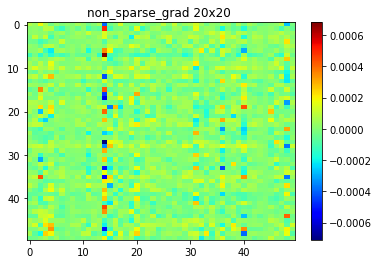

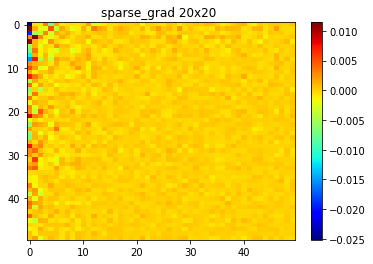

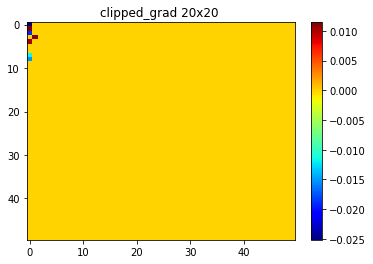

we get trashhold int 0.01
count nonzero tensor(60, device='cuda:0')


we get trashhold out 0.01
count nonzero tensor(3, device='cuda:0')




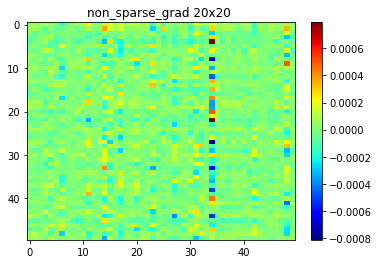

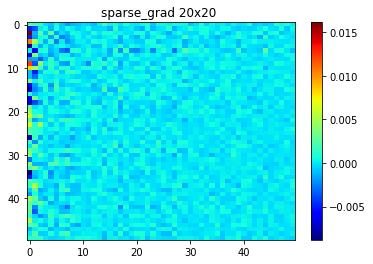

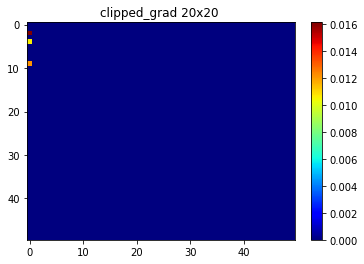

we get trashhold int 0.01
count nonzero tensor(49, device='cuda:0')


we get trashhold out 0.01
count nonzero tensor(229, device='cuda:0')


we get trashhold int 0.01
count nonzero tensor(879, device='cuda:0')


we get trashhold out 0.01
count nonzero tensor(1, device='cuda:0')


we get trashhold int 0.01
count nonzero tensor(53, device='cuda:0')


we get trashhold out 0.01
count nonzero tensor(2, device='cuda:0')


we get trashhold int 0.01
count nonzero tensor(64, device='cuda:0')


we get trashhold out 0.01
count nonzero tensor(14, device='cuda:0')


we get trashhold int 0.01
count nonzero tensor(170, device='cuda:0')


we get trashhold out 0.01
count nonzero tensor(13, device='cuda:0')


we get trashhold int 0.01
count nonzero tensor(45, device='cuda:0')


we get trashhold out 0.01
count nonzero tensor(6, device='cuda:0')


we get trashhold int 0.01
count nonzero tensor(40, device='cuda:0')


we get trashhold out 0.01
count nonzero tensor(2, device='cuda:0')


we get trashhold int 

RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 230855680 vs 230855568

In [42]:
trainer.train()

In [44]:
len(trainer.losses)

1605

In [62]:
trainer.evaluate()

{'eval_loss': 0.5122539401054382,
 'eval_matthews_correlation': 0.5701743615529957,
 'eval_combined_score': 0.5701743615529957,
 'eval_runtime': 1.4921,
 'eval_samples_per_second': 699.014,
 'eval_steps_per_second': 6.032,
 'epoch': 3.0}

In [57]:
len(sparse)

1605

In [74]:
np.mean(np.array(sparse0001[:1600]).reshape(-1, 100), axis=1)

array([0.58744633, 0.48372892, 0.45249125, 0.46957046, 0.4251396 ,
       0.3595078 , 0.3003635 , 0.31275827, 0.319962  , 0.30718932,
       0.279875  , 0.21239653, 0.18981743, 0.21794423, 0.17744812,
       0.19573309], dtype=float32)

In [60]:
len(np.mean(np.array(sparse[:1600]).reshape(-1, 100), axis=1))

16

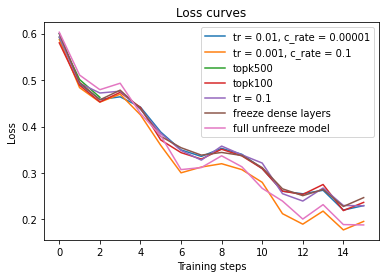

In [43]:
import matplotlib.pyplot as plt

plt.plot(np.mean(np.array(sparse001[:1600]).reshape(-1, 100), axis=1), label='tr = 0.01, c_rate = 0.00001')
plt.plot(np.mean(np.array(sparse0001[:1600]).reshape(-1, 100), axis=1), label='tr = 0.001, c_rate = 0.1')
plt.plot(np.mean(np.array(trainer.losses[:1600]).reshape(-1, 100), axis=1), label='topk500')
plt.plot(np.mean(np.array(sparse[:1600]).reshape(-1, 100), axis=1), label='topk100')
plt.plot(np.mean(np.array(sparse01[:1600]).reshape(-1, 100), axis=1), label='tr = 0.1')
plt.plot(np.mean(np.array(freeze[:1600]).reshape(-1, 100), axis=1), label='freeze dense layers')
plt.plot(np.mean(np.array(full[:1600]).reshape(-1, 100), axis=1), label='full unfreeze model')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_trasholds_v3.png")
plt.show()

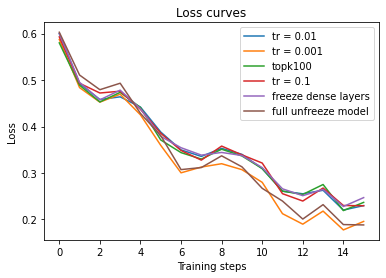

In [59]:
import matplotlib.pyplot as plt

plt.plot(np.mean(np.array(sparse001[:1600]).reshape(-1, 100), axis=1), label='tr = 0.01')
plt.plot(np.mean(np.array(trainer.losses[:1600]).reshape(-1, 100), axis=1), label='tr = 0.001')
plt.plot(np.mean(np.array(sparse[:1600]).reshape(-1, 100), axis=1), label='topk100')
plt.plot(np.mean(np.array(sparse01[:1600]).reshape(-1, 100), axis=1), label='tr = 0.1')
plt.plot(np.mean(np.array(freeze[:1600]).reshape(-1, 100), axis=1), label='freeze dense layers')
plt.plot(np.mean(np.array(full[:1600]).reshape(-1, 100), axis=1), label='full unfreeze model')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_trasholds_v2.png")
plt.show()

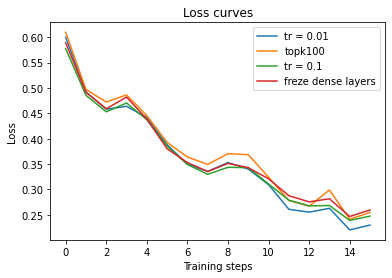

In [62]:
import matplotlib.pyplot as plt

plt.plot(np.mean(np.array(sparse001[:1600]).reshape(-1, 100), axis=1), label='tr = 0.01')
plt.plot(np.mean(np.array(trainer.losses[:1600]).reshape(-1, 100), axis=1), label='topk100')
plt.plot(np.mean(np.array(sparse01[:1600]).reshape(-1, 100), axis=1), label='tr = 0.1')
plt.plot(np.mean(np.array(freeze[:1600]).reshape(-1, 100), axis=1), label='freeze dense layers')
plt.plot(np.mean(np.array(full[:1600]).reshape(-1, 100), axis=1), label='full unfreeze model')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_trasholds.png")
plt.show()

In [35]:
trainer.train()

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.492100
1000,0.352500
1500,0.282500


TrainOutput(global_step=1605, training_loss=0.3686714778436679, metrics={'train_runtime': 246.9003, 'train_samples_per_second': 103.9, 'train_steps_per_second': 6.501, 'total_flos': 1687396975787520.0, 'train_loss': 0.3686714778436679, 'epoch': 3.0})

In [37]:
trainer.evaluate()

{'eval_loss': 0.5227116942405701,
 'eval_matthews_correlation': 0.5572696682585848,
 'eval_combined_score': 0.5572696682585848,
 'eval_runtime': 1.4878,
 'eval_samples_per_second': 701.024,
 'eval_steps_per_second': 6.049,
 'epoch': 3.0}

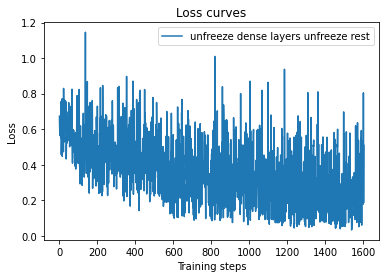

In [36]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers unfreeze rest')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_unfreeze_model.png")
plt.show()

In [46]:
trainer.train()

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.486900
1000,0.303500
1500,0.199000


TrainOutput(global_step=1605, training_loss=0.31984966789079233, metrics={'train_runtime': 177.1132, 'train_samples_per_second': 144.84, 'train_steps_per_second': 9.062, 'total_flos': 1687396975787520.0, 'train_loss': 0.31984966789079233, 'epoch': 3.0})

In [56]:
trainer.evaluate()

{'eval_loss': 0.6566889882087708,
 'eval_matthews_correlation': 0.5804132033917235,
 'eval_combined_score': 0.5804132033917235,
 'eval_runtime': 1.4725,
 'eval_samples_per_second': 708.316,
 'eval_steps_per_second': 6.112}

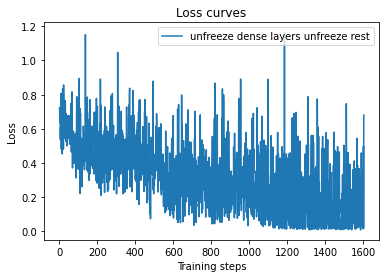

In [48]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers unfreeze rest')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_unfreeze_model.png")
plt.show()

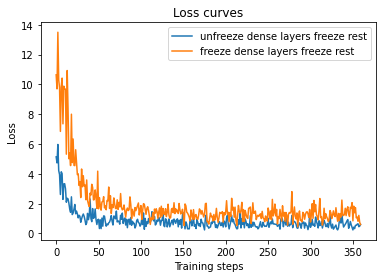

In [41]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers freeze rest')
plt.plot(freeze, label='freeze dense layers freeze rest')
#plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

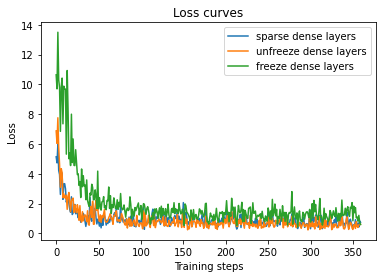

In [54]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='sparse dense layers')
plt.plot(full, label='unfreeze dense layers')
plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='all zeros')
plt.plot(full, label='full grads')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
a = np.stack(trainer.grad_bank_out[4][:28], axis = 0)
print (a.shape)
a = np.moveaxis(a, 0, 2)
print (a.shape)

In [ ]:
len(dict_int[0][4])

In [ ]:
import torch
dict_int = get_tucker_tensors(trainer.grad_bank_int)
dict_out = get_tucker_tensors(trainer.grad_bank_out)
print (dict_int[0].shape)
print (dict_int[1].shape)
for i in range(1):
    u1_int, u2_int = Tucker_Decomposition(dict_int[i])
    u1_out, u2_out = Tucker_Decomposition(dict_out[i])

In [ ]:
for i in range(1):
    print(i)

In [ ]:
print (u1_int.shape, u2_int.shape)

In [ ]:
def func_collecting_tensors(step, tensor1, tensor2=None):
    if step == 0:
        return tensor1.unsqueeze(0)
    else:
        return torch.concatenate((tensor1, tensor2),0)
    
def Tucker_Decomposition(tensor):
    n1, n2, n3 = tensor.shape
    u1, s1, v1 = np.linalg.svd(np.reshape(tensor, (n1, -1)), full_matrices=False)
    u2, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[1,2,0]), (n2, -1)), full_matrices=False)
    u3, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[2,0,1]), (n3, -1)), full_matrices=False)
    return u1, u2

def get_tucker_tensors(dict_layers):
    '''
    делает словарь где ключом будет слой, а значением будет тензор
    '''
    dict_tensor = dict(zip(range(12), [None]*12))
    for key in dict_layers.keys():
        dict_tensor[key] = np.moveaxis(np.stack(dict_layers[key][:28], axis = 0), 0, 2)
    return dict_tensor
    

In [ ]:
u1_int.T.shape

In [ ]:
matrix.shape

In [ ]:
for ind, matrix in enumerate(trainer.grad_bank_int[0][26:]):
    print ("layer", 0, "batch", ind+26)
    matrix_in_basis = u1_int.T @ matrix @ u2_int
    im= plt.imshow(matrix_in_basis, cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS ') 
    plt.colorbar(im) #not in spy
    plt.show()

    im= plt.imshow(matrix_in_basis[:50, :50], cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS '+'20x20 ') 
    plt.colorbar(im) #not in spy
    plt.show()
    print('\n\n\n\n')

In [ ]:
for ind, matrix in enumerate(trainer.grad_bank_out[0][26:]):
    print ("layer", 0, "batch", ind+26)
    matrix_in_basis = u1_out.T @ matrix @ u2_out
    im= plt.imshow(matrix_in_basis, cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS ') 
    plt.colorbar(im) #not in spy
    plt.show()

    im= plt.imshow(matrix_in_basis[:50, :50], cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS '+'20x20 ') 
    plt.colorbar(im) #not in spy
    plt.show()
    print('\n\n\n\n')

In [ ]:
import pickle

with open('regular_grad_int.pcl', 'wb') as fp:
    pickle.dump(trainer.grad_bank_int, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('regular_grad_out.pcl', 'wb') as fp:
    pickle.dump(trainer.grad_bank_out, fp, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
import pickle

with open('sparse_s.pcl', 'wb') as fp:
    pickle.dump(trainer.sparse_grad_bank_int, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('regular_grad_int.pcl', 'rb') as fp:
    data = pickle.load(fp)

In [28]:
len(data[2])

NameError: name 'data' is not defined

In [29]:
for layer in range(len(trainer.sparse_grad_bank_int)):
  for batch in range(len(trainer.sparse_grad_bank_int[layer])):
      S_hat_zero= trainer.sparse_grad_bank_int[layer][batch]
      print ("layer", layer, "batch", batch)
      im= plt.imshow(S_hat_zero, cmap='jet', aspect='auto')#not in spy
      plt.title('GRAD WEIGHTS ') 
      plt.colorbar(im) #not in spy
      plt.show()

      im= plt.imshow(S_hat_zero[:20, :20], cmap='jet', aspect='auto')#not in spy
      plt.title('GRAD WEIGHTS '+'20x20 ') 
      plt.colorbar(im) #not in spy
      plt.show()
      print('\n\n\n\n')

NameError: name 'trainer' is not defined

get proper gradients (3rd output 3 layer)

In [ ]:
trainer.grad_bank_out[3]

tensor([[ 0.0087,  0.0019,  0.0022,  ..., -0.0060, -0.0029, -0.0028],
        [-0.0242, -0.0136,  0.0077,  ...,  0.0116, -0.0138, -0.0200],
        [ 0.0011, -0.0008, -0.0025,  ...,  0.0030,  0.0122,  0.0007],
        ...,
        [ 0.0208,  0.0178,  0.0109,  ...,  0.0239, -0.0072,  0.0082],
        [ 0.0068,  0.0190,  0.0222,  ...,  0.0137,  0.0079,  0.0078],
        [ 0.0094,  0.0085,  0.0064,  ...,  0.0164, -0.0020,  0.0097]])

In [ ]:
trainer.evaluate()

{'eval_loss': 0.46737247705459595,
 'eval_pearson': 0.8913607659252257,
 'eval_spearmanr': 0.8872514922959747,
 'eval_combined_score': 0.8893061291106001,
 'eval_runtime': 10.7561,
 'eval_samples_per_second': 139.456,
 'eval_steps_per_second': 1.116,
 'epoch': 1.0}

In [ ]:
trainer.save_model()  # Saves the tokenizer too for easy upload
#trainer.log_metrics("train", metrics)
metrics = trainer.evaluate()
trainer.save_metrics("eval", metrics)
trainer.save_state()
sst_new_path = r"./bert_stsb_128"

In [ ]:
#our model's params
orig_param = trainer.model.num_parameters() / 1000 / 1000
orig_param

109.48300900000001

In [ ]:
device='cuda'
def svd_compress_bert_ffn(model_to, svd_rank = 51):
    for i in range(model_to.config.num_hidden_layers):
        # fc part
        fc_w = model_to.bert.encoder.layer[i].intermediate.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].intermediate.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].intermediate.dense = factorized_layer
        
        fc_w = model_to.bert.encoder.layer[i].output.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].output.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].output.dense = factorized_layer

In [ ]:
from typing import List, Callable
import torch
import torch.nn as nn
import tntorch as tn
from math import sqrt

from ttm_opt import einsum_forward

class TTLinearOpt(nn.Module):
    def __init__(self, in_features: int, out_features: int, ranks: List[int], input_dims: List[int],
                 output_dims: List[int], bias: bool = True, device=None, dtype=None,
                 forward_fn: Callable = einsum_forward):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ranks = list(ranks)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.forward_fn = forward_fn

        # Initialize weights from uniform[-1 / sqrt(in_features), 1 / sqrt(in_features)]
        factory_kwargs = {"device": device, "dtype": dtype}
        init = torch.rand(in_features, out_features, **factory_kwargs)
        init = (2 * init - 1) / sqrt(in_features)
        
        self.weight = tn.TTMatrix(init, list(ranks), input_dims, output_dims)

        # torch doesn't recognize attributes of self.weight as parameters,
        # so we have to use ParameterList
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

        if bias:
            init = torch.rand(out_features, **factory_kwargs)
            init = (2 * init - 1) / sqrt(out_features)
            self.bias = nn.Parameter(init)
        else:
            self.register_parameter('bias', None)


    def forward(self, x: torch.Tensor):
        res = self.forward_fn(self.cores, x)

        new_shape = x.shape[:-1] + (self.out_features,)
        res = res.reshape(*new_shape)

        if self.bias is not None:
            res += self.bias

        return res

    def set_weight(self, new_weights: torch.Tensor):
        # in regular linear layer weights are transposed, so we transpose back
        new_weights = new_weights.clone().detach().T

        shape = torch.Size((self.in_features, self.out_features))
        assert new_weights.shape == shape, f"Expected shape {shape}, got {new_weights.shape}"

        self.weight = tn.TTMatrix(new_weights, self.ranks, self.input_dims, self.output_dims)
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

    def set_from_linear(self, linear: nn.Linear):
        self.set_weight(linear.weight.data)
        self.bias = nn.Parameter(linear.bias.data.clone()) if linear.bias is not None else None

In [ ]:
def ttm_compress_bert_ffn(model, rank):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        token_dim, hidden_dim = layer.intermediate.dense.weight.T.shape

        tt_weight = TTLinearOpt(768, 3072, [rank]*2,  [8,12,8], [12,16,16], bias=True)
        tt_weight.set_from_linear(layer.intermediate.dense)

        layer.intermediate.dense = tt_weight

        # second linear layerhas reversed dimensions,
        # so we swap input_dims and output_dims
        tt_weight = TTLinearOpt(3072, 768, [rank]*2, [12,16,16], [8,12,8], bias=True)
        tt_weight.set_from_linear(layer.output.dense)

        layer.output.dense = tt_weight

    return model

In [ ]:
from tqdm import tqdm

In [ ]:
dd = []
device='cuda'
for ii in tqdm([6,10,20]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    svd_compress_bert_ffn(trainer.model, ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd.append([new_param, ar['eval_pearson']])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:35<00:00, 31.80s/it]


In [ ]:
dd_ttm = []
for ii in tqdm([6,10,20]): #,42,48,54,60,66,72,78,84]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    ttm_compress_bert_ffn(trainer.model,ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd_ttm.append([new_param, ar['eval_pearson']])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:40<00:00, 33.54s/it]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='% of original params', ylabel='1'>

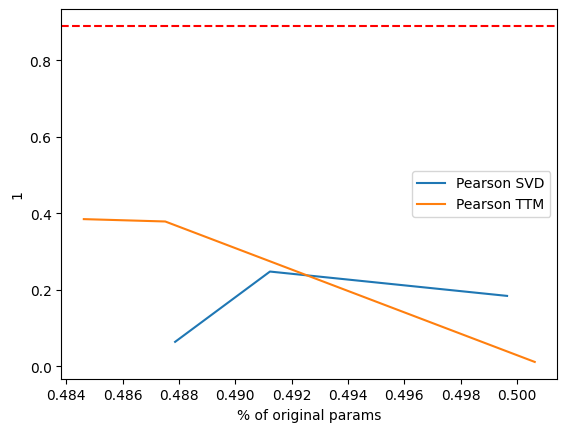

In [ ]:
ax = sns.lineplot(x=0, y=1, data = pd.DataFrame(dd), label='Pearson SVD')
plt.axhline(y=0.89, ls='--', c='red') #non-compressed accuracy
ax.set(xlabel ='% of original params')
sns.lineplot(x=0, y=1, data = pd.DataFrame(dd_ttm), label='Pearson TTM')